# Splitter tutorial

This notebook presents the possibilities of splitters. They will help to split the train and test data.
RePlay offers several classes:

* DateSplitter
* RandomSplitter
* NewUsersSplitter
* ColdUserRandomSplitter
* UserSplitter

Each of them provides its own capabilities for data split.

### Building object

To build an object, you need to specify the parameters you are interested in.

### Split data

To split the data, you must call the `.split()` method on the Splitter object

### Return

Splitters return `train` and `test` cached data frames to compute them once and re-use for models training, inference and metrics calculation.


In [138]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from replay.data_preparator import DataPreparator, Indexer
from replay.utils import convert2spark

## Get started

Download the dataset **MovieLens** and preprocess it with `DataPreparator` and `Indexer`

In [47]:
ratings = pd.read_csv('data/ratings.dat',sep="::",names=["userId", "itemId", "relevance", "timestamp"])

<ipython-input-47-54d469237e5f>:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  ratings = pd.read_csv('data/ratings.dat',sep="::",names=["userId", "itemId", "relevance", "timestamp"])


In [48]:
ratings.head(5)

,userId,itemId,relevance,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [49]:
dp = DataPreparator()
log = dp.transform(data=ratings,
                  columns_mapping={
                      "user_id": "userId",
                      "item_id":  "itemId",
                      "relevance": "relevance",
                      "timestamp": "timestamp"
                  })

log.show(2)

13-Sep-22 16:08:04, replay, INFO: Columns with ids of users or items are present in mapping. The dataframe will be treated as an interactions log.


+-------+-------+---------+-------------------+
|user_id|item_id|relevance|          timestamp|
+-------+-------+---------+-------------------+
|      1|   1193|      5.0|2001-01-01 01:12:40|
|      1|    661|      3.0|2001-01-01 01:35:09|
+-------+-------+---------+-------------------+
only showing top 2 rows



In [50]:
indexer = Indexer(user_col='user_id', item_col='item_id')
indexer.fit(users=log.select('user_id'),
            items=log.select('item_id'))
log = indexer.transform(df=log)
log.show(2)

+--------+--------+---------+-------------------+
|user_idx|item_idx|relevance|          timestamp|
+--------+--------+---------+-------------------+
|    4131|      43|      5.0|2001-01-01 01:12:40|
|    4131|     585|      3.0|2001-01-01 01:35:09|
+--------+--------+---------+-------------------+
only showing top 2 rows



Function for viewing `train`, `test` data

In [51]:
def show_train_test(train, test, user_cat, figs=(15,6),alph=1):
    plt.figure(figsize=figs)
    sns.set_theme(style="whitegrid", palette="muted")
    train_plt = train.toPandas()
    train_plt["split"] = 'train'
    test_plt = test.toPandas()
    test_plt["split"] = 'test'
    pd_for_print = pd.concat((train_plt, test_plt), axis=0)
    if user_cat:
        pd_for_print["user_idx"] = pd_for_print["user_idx"].astype(str)
    sns.scatterplot(data=pd_for_print, x="timestamp", y="user_idx", hue="split",s=8*8,alpha=alph)
    plt.autoscale(enable=True, axis='x')
    plt.grid(False)
    plt.show()

## class DateSplitter()

Split into train and test by date.

### Parameters

* `test_start` string "yyyy-mm-dd" , int unix timestamp, datetime or a fraction for test size to determine the date automatically

* `drop_cold_users` flag to drop cold items from test

* `drop_cold_items` flag to drop cold users from test

* `drop_zero_rel_in_test` flag to remove entries with relevance <= 0

* `date_col` timestamp column name

* `user_col` user id column name

* `item_col` item id column name


In this example `test_start` parameter will take fraction for test size

In [128]:
from replay.splitters.log_splitter import DateSplitter

date_splitter = DateSplitter(
    test_start=0.005,
    drop_cold_users=True,
    drop_cold_items=True,
    drop_zero_rel_in_test=True
)

In [126]:
train, test = date_splitter.split(log)

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


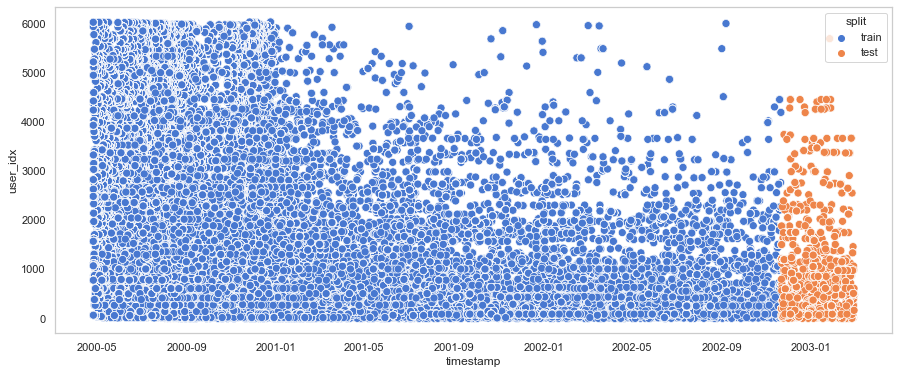

In [127]:
show_train_test(train, test, 0)

In this example `test_start` parameter will take string "yyyy-mm-dd"

In [129]:
from replay.splitters.log_splitter import DateSplitter

date_splitter = DateSplitter(
    test_start="2001-09",
    drop_cold_users=True,
    drop_cold_items=True,
    drop_zero_rel_in_test=True
)

In [11]:
train, test = date_splitter.split(log)

/opt/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


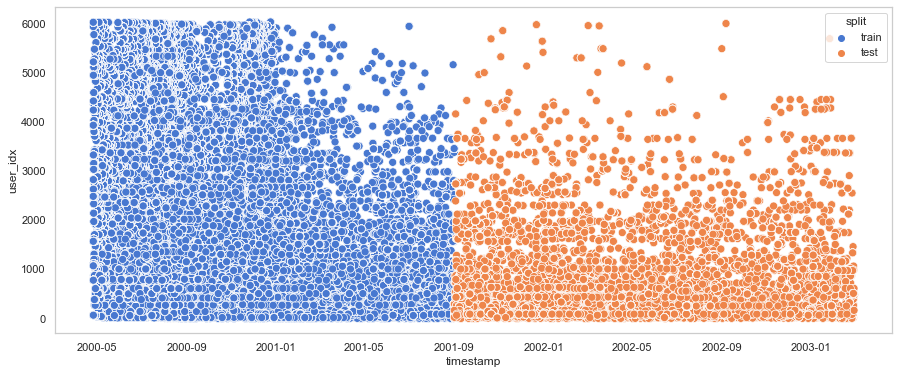

In [12]:
show_train_test(train, test, 0)

## class RandomSplitter()

Assign records into train and test at random.

#### Parameters

* `test_size` float 

* `drop_cold_users` flag to drop cold items from test

* `drop_cold_items` flag to drop cold users from test

* `drop_zero_rel_in_test` flag to remove entries with relevance <= 0

* `seed` random seed

* `date_col` timestamp column name

* `user_col` user id column name

* `item_col` item id column name

In [130]:
from replay.splitters.log_splitter import RandomSplitter

random_splitter = RandomSplitter(
    test_size=0.4,
    drop_cold_users=True,
    drop_cold_items=True,
    drop_zero_rel_in_test=True
)

In [74]:
log_limit_50 = log.filter("user_idx < 50")

In [75]:
train, test = random_splitter.split(log_limit_50)

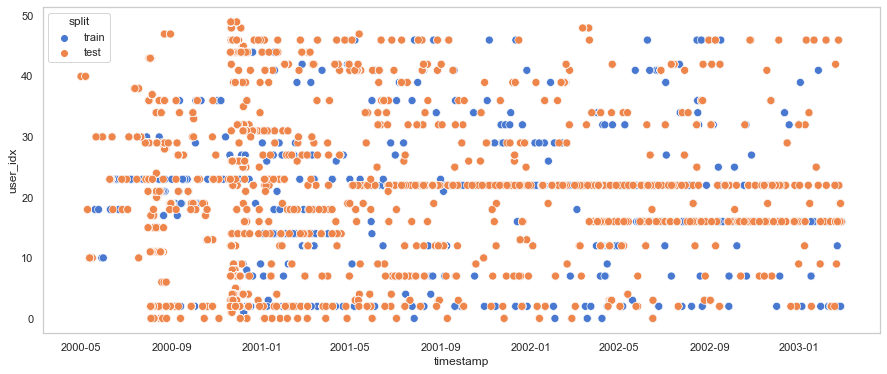

In [76]:
show_train_test(train, test, 0)

## class NewUsersSplitter()

Only new users will be assigned to test set.
Splits log by timestamp so that test has `test_size` fraction of most recent users.

#### Parameters

* `test_size` float 

* `drop_cold_users` flag to drop cold items from test

* `drop_cold_items` flag to drop cold users from test

* `drop_zero_rel_in_test` flag to remove entries with relevance <= 0

* `date_col` timestamp column name

* `user_col` user id column name

* `item_col` item id column name

In [131]:
from replay.splitters.log_splitter import NewUsersSplitter

new_user_splitter = NewUsersSplitter(
    test_size=0.3
)

In [133]:
log_limit_20 = log.filter("user_idx < 20")
train, test = new_user_splitter.split(log_limit_20)

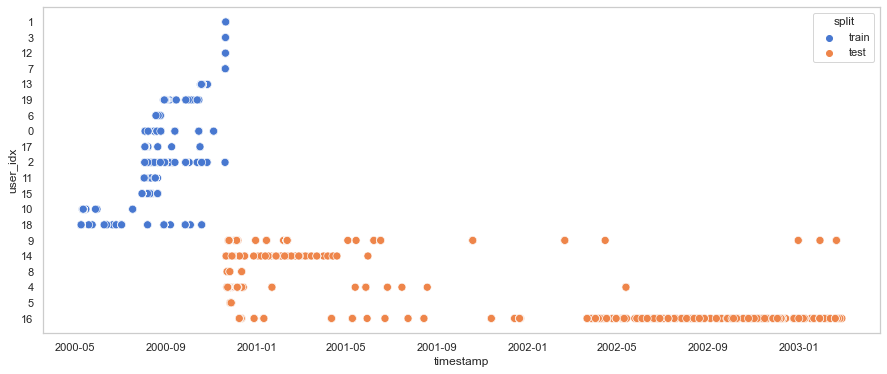

In [22]:
show_train_test(train, test, 1)

## class ColdUserRandomSplitter()

Test set consists of all actions of randomly chosen users.

#### Parameters

* `test_size` float 

* `drop_cold_users` flag to drop cold items from test

* `drop_cold_items` flag to drop cold users from test

* `drop_zero_rel_in_test` flag to remove entries with relevance <= 0

* `seed` random seed

* `date_col` timestamp column name

* `user_col` user id column name

* `item_col` item id column name

In [136]:
from replay.splitters.log_splitter import ColdUserRandomSplitter

cold_user_random_splitter = ColdUserRandomSplitter(
    test_size=0.3
)

In [137]:
log_limit_20 = log.filter("user_idx < 20")
train, test = cold_user_random_splitter.split(log_limit_20)

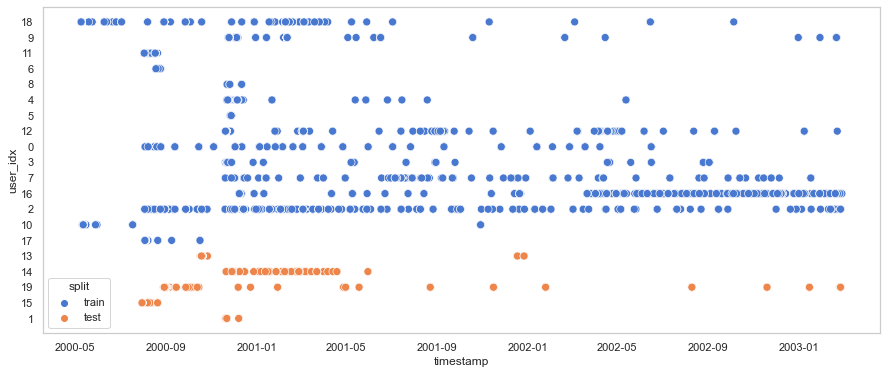

In [31]:
show_train_test(train, test,1)

## class UserSplitter()

Split data inside each user's history separately.

#### Parameters

* `item_test_size` Number of items to be added to the test for each user

* `user_test_size` Number of users to be added to the test

* `drop_cold_users` flag to drop cold items from test

* `drop_cold_items` flag to drop cold users from test

* `drop_zero_rel_in_test` flag to remove entries with relevance <= 0

* `seed` random seed

* `date_col` timestamp column name

* `user_col` user id column name

* `item_col` item id column name

In this example 10 users are randomly selected, 50 products are included in the test for each user. `shuffle` parameter is False. Separation in each selected user occurs on a timeline

In [140]:
from replay.splitters.user_log_splitter import UserSplitter

user_splitter = UserSplitter(
    item_test_size=50,
    user_test_size=10,
    shuffle=False
)

In [109]:
train, test = user_splitter.split(log_limit_20)

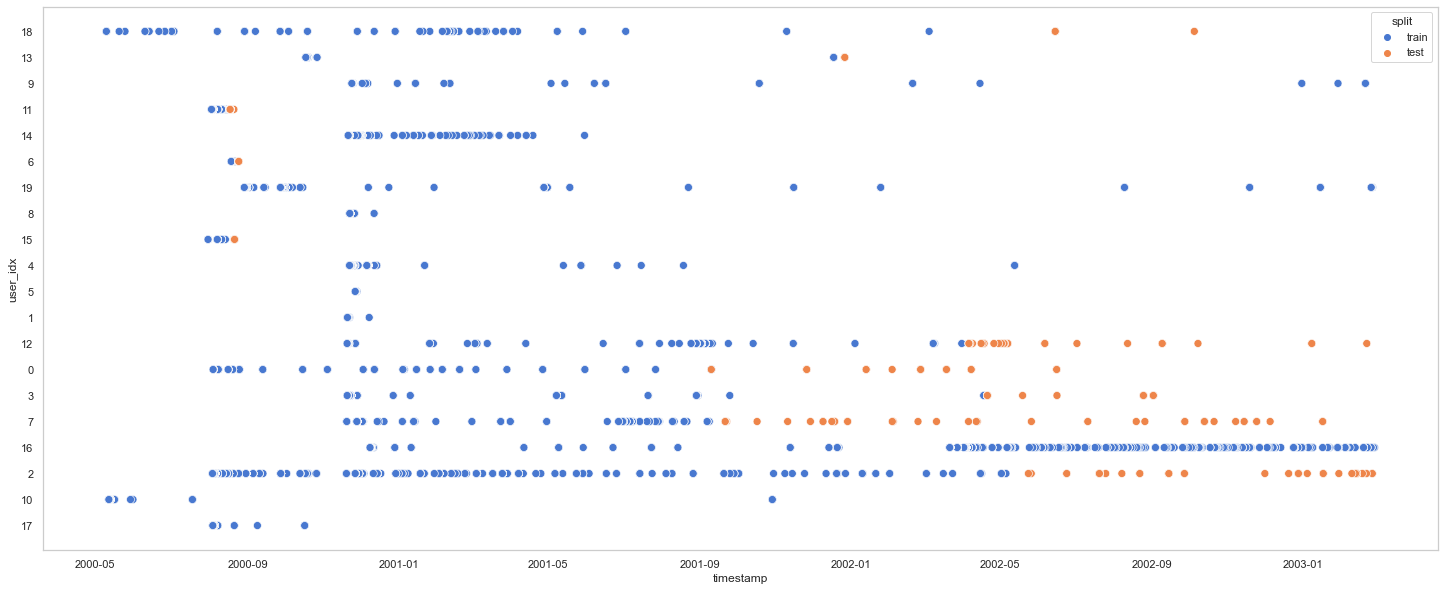

In [117]:
show_train_test(train, test, 1,(25,10))

In this example 10 users are randomly selected, 50 products are included in the test for each user. In this example `shuffle` parameter is True. Split in each selected user occurs random

In [139]:
from replay.splitters.user_log_splitter import UserSplitter

user_splitter = UserSplitter(
    item_test_size=50,
    user_test_size=10,
    shuffle=True
)

In [120]:
train, test = user_splitter.split(log_limit_20)

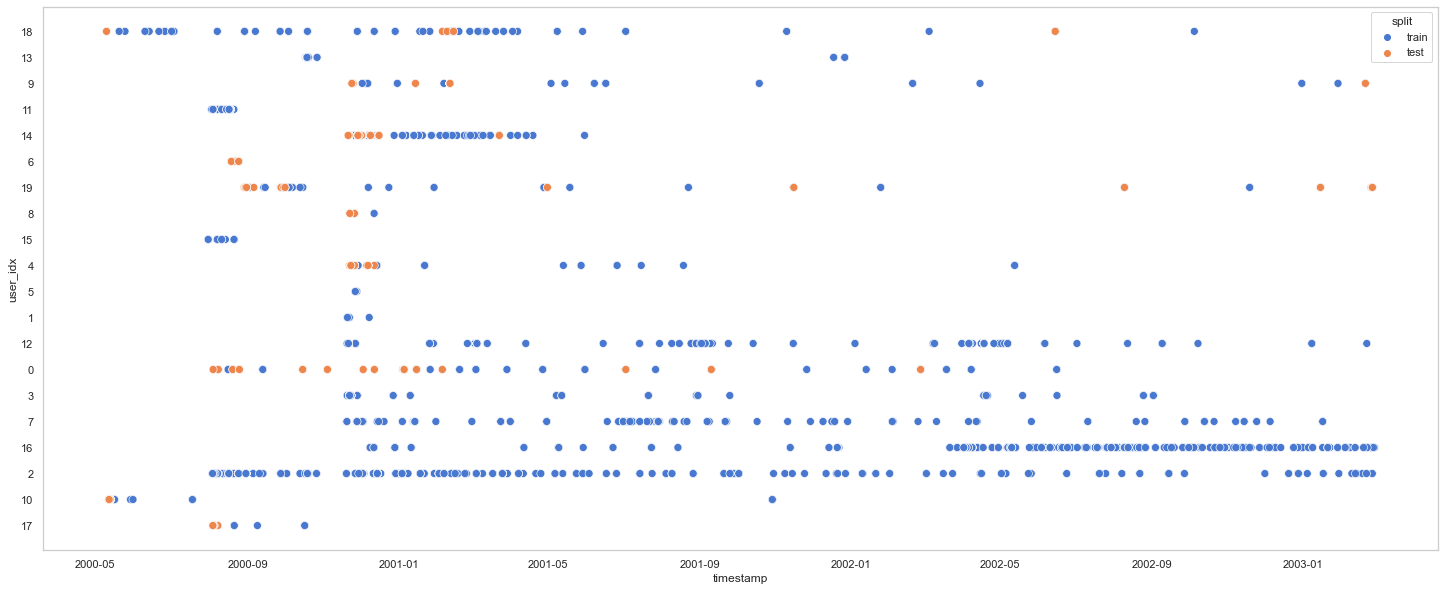

In [121]:
show_train_test(train, test, 1,(25,10))